In [2]:
import geopandas as gpd
print(gpd.__version__)
import pandas as pd
import os
import matplotlib.pyplot as plt


0.14.3


Merge Polygons to Single Shapefile

In [2]:
import os

dir = "/data/sand_mining/osm/osm_river_new"
geo_dfs = []

for filename in os.listdir(dir):
    if filename.endswith(".geojson"):
        file_path = os.path.join(dir, filename)
        geo_df = gpd.read_file(file_path)
        geo_dfs.append(geo_df)

combined_geo_df = pd.concat(geo_dfs, ignore_index=True)

print(combined_geo_df.astype)


<bound method GeoDataFrame.astype of                       id               @id SWBD_cell SWBD_facc_code SWBD_wb  \
0       relation/1439515  relation/1439515      None           None    None   
1       relation/1439517  relation/1439517      None           None    None   
2       relation/4613177  relation/4613177      None           None    None   
3       relation/5459534  relation/5459534      None           None    None   
4       relation/6005801  relation/6005801      None           None    None   
...                  ...               ...       ...            ...     ...   
240923    way/1259719820    way/1259719820       NaN            NaN     NaN   
240924     way/497019566     way/497019566       NaN            NaN     NaN   
240925   node/4007150372   node/4007150372       NaN            NaN     NaN   
240926   node/8245467571   node/8245467571       NaN            NaN     NaN   
240927   node/8245467572   node/8245467572       NaN            NaN     NaN   

       alt_nam

In [3]:
combined_geo_df.shape

(240928, 364)

In [4]:
combined_geo_df.geometry.type

0            Polygon
1            Polygon
2            Polygon
3            Polygon
4            Polygon
             ...    
240923       Polygon
240924    LineString
240925         Point
240926         Point
240927         Point
Length: 240928, dtype: object

In [5]:
# Save Points and Lines and Polygons in separate shapefiles
points_df = combined_geo_df[combined_geo_df.geometry.type == 'Point']
lines_df = combined_geo_df[combined_geo_df.geometry.type == 'LineString']
polygons_df = combined_geo_df[combined_geo_df.geometry.type == 'Polygon']

points_df.shape, lines_df.shape, polygons_df.shape

((629, 364), (1342, 364), (238826, 364))

In [6]:
#Only save the shapefiles with polygons data type
polygons_df.to_file("/data/sand_mining/osm/osm_india_rivers_wr.shp")

/data/tmp/ipykernel_1846964/3145936328.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  polygons_df.to_file("/data/sand_mining/osm/osm_india_rivers_wr.shp")


In [3]:
river_polygons = gpd.read_file("/data/sand_mining/osm/osm_india_rivers_wr.shp")
river_polygons.head()

In [10]:
river_centerlines = gpd.read_file("/data/sand_mining/rivers/india_gov/Rivers.shp")
river_centerlines.head()

Validate the Matching Polygons Using Spatial Join

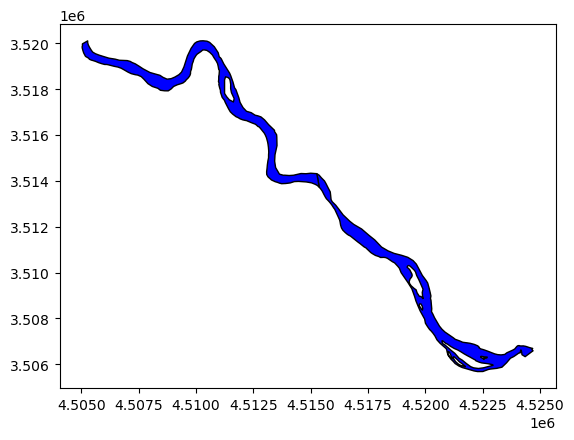

In [42]:
polygon1 = river_polygons.loc[0, "geometry"]
polygon2 = river_polygons.loc[1, "geometry"]

gdf_combined_polygons = gpd.GeoDataFrame([{'geometry': polygon1}, {'geometry': polygon2}], crs=river_polygons.crs)
ax = gdf_combined_polygons.plot(color='blue', edgecolor='black')


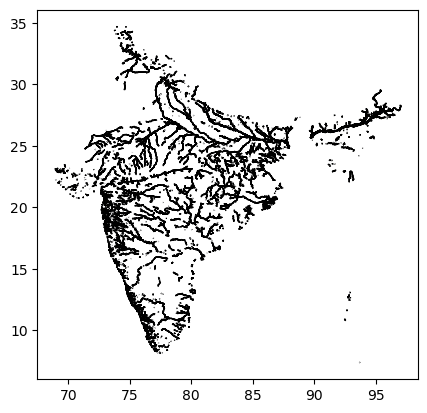

In [14]:
ax = river_polygons.plot(color='blue', edgecolor='black')
ax.set_aspect('equal')
plt.show()

/home/irenevanessa/miniconda3/envs/geopandas_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/data/tmp/ipykernel_1682361/2213682566.py:9: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  matched_rivers.plot(ax=ax, color='green', label='Matched Natural Rivers', alpha=0.5)


<Axes: >

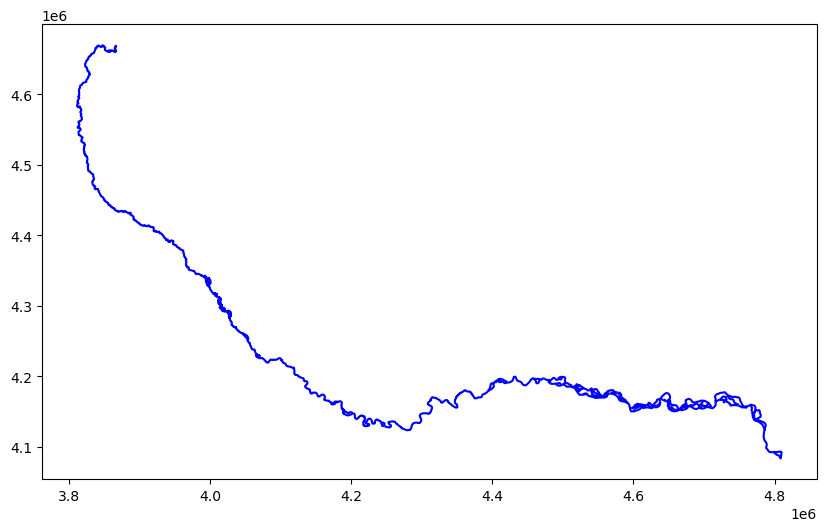

In [30]:
centerline = river_centerlines[river_centerlines['rivname'] == 'Ganga']

# Spatial join
matched_rivers = gpd.sjoin(river_natural, centerline, how='inner', op='within')

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
centerline.plot(ax=ax, color='blue', label=' River Centerline')
matched_rivers.plot(ax=ax, color='green', label='Matched Natural Rivers', alpha=0.5)

/home/irenevanessa/miniconda3/envs/geopandas_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/data/tmp/ipykernel_1682361/1582020548.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: PROJCS["WGS_1984_Lambert_Conformal_Conic",GEOGCS[" ...

  joined_gdf = gpd.sjoin(river_polygons, river_centerlines, how="left", op="intersects")


<Axes: >

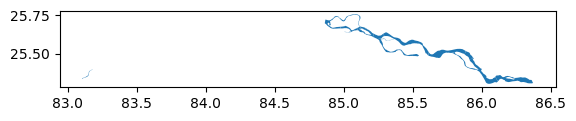

In [29]:
joined_gdf = gpd.sjoin(river_polygons, river_centerlines, how="left", op="intersects")
matched_rivers_gdf = joined_gdf[joined_gdf['name'].notna()]
matched_rivers_gdf[matched_rivers_gdf['name']=="Ganga"].plot()

Match Centerlines to Polygons and Save To Server

In [37]:
output_dir = "/data/sand_mining/osm/osm_rivers_matched_new"
os.makedirs(output_dir, exist_ok=True)

river_polygons = river_polygons.to_crs(river_centerlines.crs)

for idx, river in river_centerlines.iterrows():
    matched_polygons = gpd.sjoin(river_polygons, gpd.GeoDataFrame([river], geometry='geometry', crs=river_centerlines.crs), how="inner", op="intersects")
    if not matched_polygons.empty:
        matched_polygons = matched_polygons.drop(columns=['index_right'])

        # Format valid filename
        river_name = river['rivname'].replace(' ', '_').replace('/', '_')
        # Save each polygon correspond to the centerline names
        output_filepath = os.path.join(output_dir, f"{river_name}.shp")
        matched_polygons.to_file(output_filepath)

/home/irenevanessa/miniconda3/envs/geopandas_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/irenevanessa/miniconda3/envs/geopandas_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/irenevanessa/miniconda3/envs/geopandas_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/irenevanessa/miniconda3/envs/geopandas_env/lib/python3.12/site-packages/IPython/co

<Axes: >

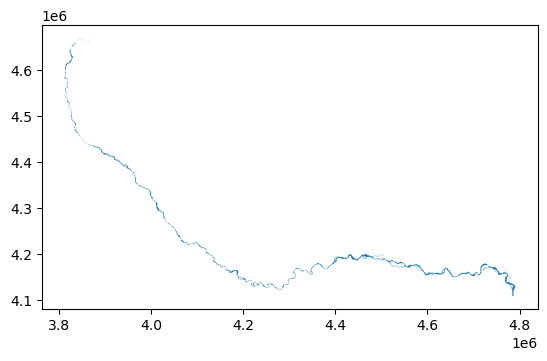

In [40]:
#Validate The Result
ganga_polygons = gpd.read_file("/data/sand_mining/osm/osm_rivers_matched/Ganga.shp")
ganga_polygons.plot()
